# **🏠 부동산 실거래가 code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [1]:
# %pip install eli5==0.13.0

# # 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

# %pip install pycaret

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.


In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
from sklearn.neighbors import BallTree

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance

# Network
import requests
import json

from pycaret.regression import *

## 2. Data Load

#### 2.1. 데이터 로드

In [3]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
unique_addr_path = '../unique_address.csv'
unique_YX_poi_path = '/data/ephemeral/home/unique_YX_poi.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)
duplicated_addr_df = pd.read_csv(unique_addr_path)
df_unique_YX = pd.read_csv(unique_YX_poi_path)

In [4]:
# 카카오 API KEY 준비
# KAKAO_API_KEY = 'cb6d5d8a448c1a2344a636a2888775aa'

In [5]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [6]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [7]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [8]:
# 컬럼 이름 변경
concat = concat.rename(columns={'전용면적(㎡)':'전용면적',
                                'k-단지분류(아파트,주상복합등등)':'단지분류', 
                                'k-전화번호':'전화번호', 
                                'k-팩스번호':'팩스번호',
                                'k-세대타입(분양형태)':'세대타입',
                                'k-관리방식':'관리방식',
                                'k-복도유형':'복도유형', 
                                'k-난방방식':'난방방식',
                                'k-전체동수':'전체동수', 
                                'k-전체세대수':'전체세대수',
                                'k-건설사(시공사)':'건설사',
                                'k-시행사':'시행사',
                                'k-연면적':'연면적',
                                'k-주거전용면적':'주거전용면적',
                                'k-관리비부과면적':'관리비부과면적',
                                'k-전용면적별세대현황(60㎡이하)':'전용면적<60',
                                'k-전용면적별세대현황(60㎡~85㎡이하)':'전용면적60~85',
                                'k-85㎡~135㎡이하':'전용면적85~135',
                                'k-135㎡초과':'전용면적>135', 
                                'k-홈페이지':'홈페이지',
                                'k-등록일자':'등록일자', 
                                'k-수정일자':'수정일자'})

In [9]:
# 중복된 행 여부를 나타내는 불리언 시리즈 생성
duplicate_rows = concat.duplicated(subset=['도로명'])

# 중복된 행의 수 계산
num_duplicates = duplicate_rows.sum()

print(f"'도로명'을 기준으로 중복된 행의 수: {num_duplicates}개")
print(f"전체에서 중복된 데이터를 뺀 개수: {len(concat) - num_duplicates}개")

'도로명'을 기준으로 중복된 행의 수: 1118849개
전체에서 중복된 데이터를 뺀 개수: 9245개


In [10]:
unique_addr_df = concat[['시군구', '번지', '도로명', '아파트명', '좌표X', '좌표Y']].drop_duplicates(subset='도로명')
display(len(unique_addr_df))
display(unique_addr_df.head())

9245

,시군구,번지,도로명,아파트명,좌표X,좌표Y
0,서울특별시 강남구 개포동,658-1,언주로 3,개포6차우성,127.057210,37.476763
12,서울특별시 강남구 개포동,652,개포로 307,개포우성3차,127.055990,37.483894
25,서울특별시 강남구 개포동,12-2,개포로109길 69,개포자이,127.076624,37.496296
38,서울특별시 강남구 개포동,141,개포로 310,개포주공1단지,127.058521,37.480002
44,서울특별시 강남구 개포동,141,선릉로 7,개포주공1단지,127.058521,37.480002


In [11]:
display(concat.index)
display(unique_addr_df.index)
duplicated_addr_df.index = unique_addr_df.index
display(duplicated_addr_df.index)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271],
           dtype='int64', length=1128094)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

Int64Index([   0,   12,   25,   38,   44,  204,  242,  289,  309,  324,
            ...
            1274, 1370, 2138, 2429, 3161, 4581, 4738, 6087, 8880, 9050],
           dtype='int64', length=9245)

In [12]:
# '도로명' 컬럼이 문자열 타입인지 확인하고 통일합니다.
concat['도로명'] = concat['도로명'].astype(str)
duplicated_addr_df['도로명'] = duplicated_addr_df['도로명'].astype(str)

In [13]:
# 서브 데이터프레임에서 '도로명'을 인덱스로 설정합니다.
duplicated_addr_df.set_index('도로명', inplace=True)

In [14]:
# 서브 데이터프레임에서 '좌표X'와 '좌표Y'의 딕셔너리 생성
coord_x_map = duplicated_addr_df['좌표X']
coord_y_map = duplicated_addr_df['좌표Y']

# 메인 데이터프레임의 '좌표X' 결측치 채우기
concat['좌표X'] = concat['좌표X'].fillna(concat['도로명'].map(coord_x_map))

# 메인 데이터프레임의 '좌표Y' 결측치 채우기
concat['좌표Y'] = concat['좌표Y'].fillna(concat['도로명'].map(coord_y_map))

In [15]:
# 결측치가 있는 행 확인
missing_coords = concat[concat['좌표X'].isnull() | concat['좌표Y'].isnull()]
print(missing_coords)

Empty DataFrame
Columns: [시군구, 번지, 본번, 부번, 아파트명, 전용면적, 계약년월, 계약일, 층, 건축년도, 도로명, 해제사유발생일, 등기신청일자, 거래유형, 중개사소재지, 단지분류, 전화번호, 팩스번호, 단지소개기존clob, 세대타입, 관리방식, 복도유형, 난방방식, 전체동수, 전체세대수, 건설사, 시행사, k-사용검사일-사용승인일, 연면적, 주거전용면적, 관리비부과면적, 전용면적<60, 전용면적60~85, 전용면적85~135, 전용면적>135, 홈페이지, 등록일자, 수정일자, 고용보험관리번호, 경비비관리형태, 세대전기계약방법, 청소비관리형태, 건축면적, 주차대수, 기타/의무/임대/임의=1/2/3/4, 단지승인일, 사용허가여부, 관리비 업로드, 좌표X, 좌표Y, 단지신청일, target, is_test]
Index: []

[0 rows x 53 columns]


In [16]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat['시'] = concat['시군구'].map(lambda x : x.split()[0])
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])
del concat['시군구']

# 계약년월 split
concat['계약년'] = concat['계약년월'].astype('str').map(lambda x : x[:4])
concat['계약월'] = concat['계약년월'].astype('str').map(lambda x : x[4:])
del concat['계약년월']

In [17]:
concat.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '해제사유발생일',
       '등기신청일자', '거래유형', '중개사소재지', '단지분류', '전화번호', '팩스번호', '단지소개기존clob',
       '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사',
       'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85',
       '전용면적85~135', '전용면적>135', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태',
       '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일',
       '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시',
       '구', '동', '계약년', '계약월'],
      dtype='object')

In [18]:
# 각 컬럼 별 값을 변경
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)
# concat.loc[concat['층'] < 0, '층'] = 1
concat['단지분류'] = concat['단지분류'].replace('도시형 생활주택(주상복합)', '주상복합')
concat['단지분류'] = concat['단지분류'].replace('도시형 생활주택(아파트)', '아파트')
concat['아파트명'] = concat['아파트명'].fillna('이름없음')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

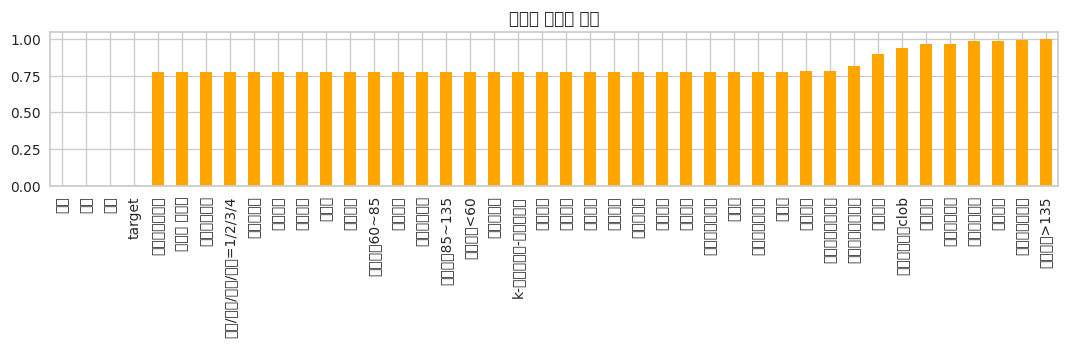

In [19]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

In [20]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', 'k-사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '시', '구', '동', '계약년', '계약월']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', '전용면적>135', '홈페이지', '등록일자']


In [21]:
# 위에서 결측치가 100만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
dt_concat_select = concat[selected]

In [22]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
dt_concat_select['본번'] = dt_concat_select['본번'].astype('str')
dt_concat_select['부번'] = dt_concat_select['부번'].astype('str')

In [23]:
dt_concat_select['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [24]:
dt_train = dt_concat_select.query('is_test==0')
dt_test = dt_concat_select.query('is_test==1')

In [25]:
# 피쳐 드랍하기 이전중복 데이터 확인 후 제거  
pd.Series(dt_train.duplicated()).value_counts()
dt_train[dt_train.duplicated(keep=False)].sort_values(by=list(dt_train.columns)).head(10)
dt_train = dt_train.drop_duplicates(keep='first')
pd.Series(dt_train.duplicated()).value_counts()

False    1115737
dtype: int64

In [26]:
dt_train['target'] = np.log1p(dt_train['target'])

In [27]:
dt_concat_select = pd.concat([dt_train, dt_test])     # 하나의 데이터로 만들어줍니다.

In [28]:
dt_concat_select['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1115737
1       9272
Name: is_test, dtype: int64

In [29]:
dt_concat_select.shape

(1125009, 48)

In [30]:
# # 상관관계가 높은 변수들을 제거
columns_to_drop = ['관리비부과면적', '주거전용면적', '전체세대수']
dt_concat_select = dt_concat_select.drop(columns=columns_to_drop)

### 범주형/연속형 baseline 변수 보간

In [31]:
# # 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
# continuous_columns = []
# categorical_columns = []

# for column in dt_concat_select.columns:
#     if pd.api.types.is_numeric_dtype(dt_concat_select[column]):
#         continuous_columns.append(column)
#     else:
#         categorical_columns.append(column)

# print("연속형 변수:", continuous_columns)
# print("범주형 변수:", categorical_columns)

In [32]:
# # 범주형 변수에 대한 보간
# dt_concat_select[categorical_columns] = dt_concat_select[categorical_columns].fillna('NULL')

# # 연속형 변수에 대한 보간 (선형 보간)
# dt_concat_select[continuous_columns] = dt_concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [33]:
# dt_concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

### 변수 보간

In [34]:
dt_temp = dt_concat_select.copy()

In [35]:
# 위에서 피쳐 드랍을 했으니 다시 범주형, 연속형 변수 분리
continuous_columns = []
categorical_columns = []

for column in dt_temp.columns:
    if pd.api.types.is_numeric_dtype(dt_temp[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '연면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월']


In [36]:
dt_temp[continuous_columns].isnull().sum()

전용면적               0
계약일                0
층                  0
건축년도               0
전체동수          874890
연면적           873810
전용면적<60       873855
전용면적60~85     873855
전용면적85~135    873855
건축면적          873963
주차대수          873961
좌표X                0
좌표Y                0
target          9272
is_test            0
dtype: int64

In [37]:
# dt_concat_select['층'] = np.log1p(dt_concat_select['층'])

In [38]:
# # 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
# fig = plt.figure(figsize=(7, 3))
# sns.histplot(data = dt_concat_select, x = "층", color="lightgreen")
# plt.title("층")
# plt.xlabel('Area')
# plt.show()

In [39]:
# dt_temp = dt_temp.dropna(subset=['아파트명', '번지'])

In [40]:
# # 전체동수 (기준: 아파트명, 동)
# def regression_imputation(df = dt_temp):
#     # 결측치가 없는 데이터로 모델 학습
#     df_train = df.dropna(subset=['전체동수']).reset_index(drop=True)
    
#     # 범주형 변수 인코딩
#     df_encoded = df.copy().reset_index(drop=True)
#     df_encoded['아파트명_encoded'] = LabelEncoder().fit_transform(df['아파트명'])
#     df_encoded['동_encoded'] = LabelEncoder().fit_transform(df['동'])
    
#     # 모델 학습
#     model = RandomForestRegressor(n_estimators=100, random_state=42)
#     X_train = df_encoded.loc[df_train.index, ['아파트명_encoded', '동_encoded']]
#     y_train = df_train['전체동수']
#     model.fit(X_train, y_train)
    
#     # 결측치 예측
#     mask = df['전체동수'].isna()
#     X_missing = df_encoded.loc[mask.reset_index(drop=True), ['아파트명_encoded', '동_encoded']]
#     df.loc[mask, '전체동수'] = model.predict(X_missing)
    
#     return df

In [41]:
# 적용
# dt_concat_select = regression_imputation(df = dt_temp)

In [42]:
# dt_concat_select['전체동수']

In [43]:
# 범주형 변수에 대한 보간
dt_concat_select[categorical_columns] = dt_concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
dt_concat_select[continuous_columns] = dt_concat_select[continuous_columns].interpolate(method='linear', axis=0)

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.

In [44]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(dt_concat_select.shape)

(1125009, 45)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

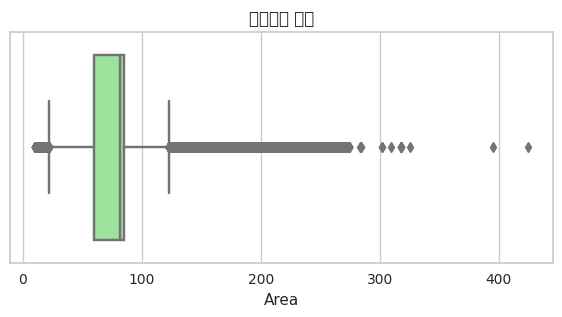

In [45]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt_concat_select, x = "전용면적", color="lightgreen")
plt.title("전용면적 분포")
plt.xlabel('Area')
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

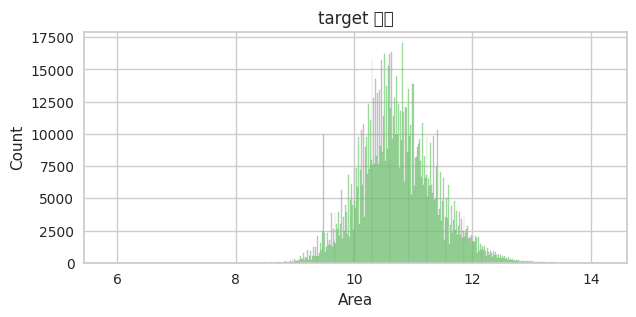

In [46]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.histplot(data = dt_concat_select, x = "target", color="lightgreen")
plt.title("target 분포")
plt.xlabel('Area')
plt.show()

In [47]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
def remove_outliers_iqr(dt, column_name):
    df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
    df_test = dt.query('is_test == 1')

    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
    return result

In [48]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
dt_concat_select = remove_outliers_iqr(dt_concat_select, '전용면적')

In [49]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(dt_concat_select.shape)

(1036122, 45)


## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [50]:
# 구 티어 
goo = list(dt_concat_select['구'].unique())

tier1 = ['강남구', '서초구', '용산구', '송파구', '성동구']
tier2 = ['마포구', '광진구', '동작구', '영등포구', '중구', '종로구', '강동구', '양천구', '서대문구']
tier3 = [x for x in goo if x not in tier1 + tier2]

assert len(goo) == len(tier1) + len(tier2) + len(tier3)       # 알맞게 분리되었는지 체크합니다.

In [51]:
# 강남의 여부를 체크합니다.
goo_tier = []
for x in dt_concat_select['구'].tolist() :
  if x in tier1 :
    goo_tier.append(1)  
  elif x in tier2 :
    goo_tier.append(2)
  else :
    goo_tier.append(3)

# 파생변수를 하나 만릅니다.
dt_concat_select['구 티어'] = goo_tier

In [52]:
# 동 티어
dong = list(dt_concat_select['동'].unique())

# Define tiers
t1 = ['반포동', '개포동', '압구정동', '대치동', '잠원동', '잠실동', '일원동', '수서동', '평동', '홍파동', '삼성동', '청담동', '도곡동', '교북동', '성수동1가', '한남동', '용강동']
t2 = ['아현동', '신계동', '신천동', '역삼동', '보광동', '용산동5가', '북아현동', '만리동2가','용문동', '자곡동', '신원동', '이촌동', '성수동2가', '상수동', '서빙고동', '옥수동', '금호동4가', '고덕동', '금호동2가', '세곡동', '장지동', '현석동', '내곡동']
t3 = ['상왕십리동', '우면동', '염리동', '흑석동', '서초동', '한강로3가', '논현동', '여의도동', '방배동', '대흥동', '광장동', '상일동', '공덕동', '한강로1가', '방이동', '영등포동7가', '토정동', '중림동', '금호동1가', '원효로4가', '행당동', '신공덕동', '하왕십리동', '원효로1가', '동작동', '송파동', '만리동1가', '이태원동', '목동']


# Convert back to list if needed
t4 = [x for x in dong if x not in t1 + t2 + t3]

# # Check if all 'dong' are categorized
assert len(dong) == len(t1) + len(t2) + len(t3) + len(t4), "Mismatch in tier categorization"

In [53]:
dong_tier = []
for x in dt_concat_select['동'].tolist() :
    if x in t1 :
        dong_tier.append(1)
    elif x in t2 :
        dong_tier.append(2)
    else :
        dong_tier.append(3)
dt_concat_select['동 티어'] = dong_tier

In [54]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
dt_concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.036122e+06
mean     1.998577e+03
std      9.127290e+00
min      1.961000e+03
10%      1.987000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.009000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

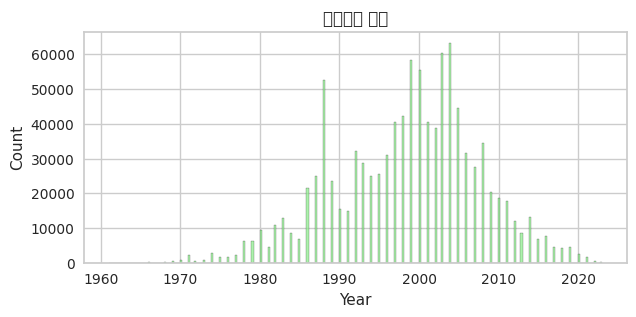

In [55]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.histplot(data = dt_concat_select, x = "건축년도", color="lightgreen")
plt.title("건축년도 분포")
plt.xlabel('Year')
plt.show()

In [56]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
dt_concat_select['신축여부'] = dt_concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

### POI 개수
- 카카오 API를 활용하여 얻었습니다. 지금은 저장된 데이터를 불러와 활용합니다.

In [57]:
display(df_unique_YX.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8345 entries, 0 to 8344
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   좌표Y     8345 non-null   float64
 1   좌표X     8345 non-null   float64
 2   POI_개수  8345 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 195.7 KB


None

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

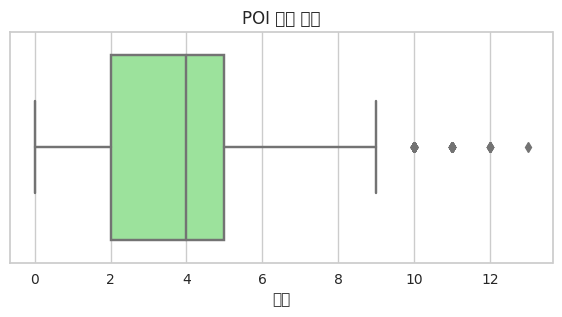

In [58]:
# “POI_개수” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = df_unique_YX, x = "POI_개수", color="lightgreen")
plt.title("POI 개수 분포")
plt.xlabel('개수')
plt.show()

In [59]:
# 메인 데이터프레임과 서브 데이터프레임 병합
dt_concat_select = pd.merge(dt_concat_select, df_unique_YX, on=['좌표Y', '좌표X'], how='left')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

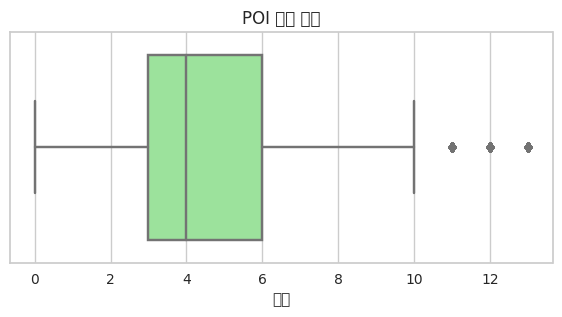

In [60]:
# 병합 후 메인 데이터프레임의 “POI_개수” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt_concat_select, x = "POI_개수", color="lightgreen")
plt.title("POI 개수 분포")
plt.xlabel('개수')
plt.show()

In [61]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
dt_concat_select = remove_outliers_iqr(dt_concat_select, 'POI_개수')

#### 아파트 브랜드

In [62]:
# 브랜드별 카테고리화
def categorize_brand(brand):
    if any(b in brand for b in ['디에이치', '푸르지오써밋', '르엘', '오티에르', '아크로', '위브더제니스', '써밋', '드파인']):
        return '하이엔드'
    elif any(b in brand for b in ['힐스테이트', '푸르지오', '롯데캐슬','더샵', 'e편한세상','래미안','아이파크','위브', '우미린', '한화포레나', '서희스타힐스','더플래티넘','한라비발디','호반베르디움','데시앙','센트레빌','자이','SK뷰','하늘채','스위첸']):
        return '1군'
    else:
        return '기타'

dt_concat_select['브랜드등급'] = dt_concat_select['아파트명'].apply(categorize_brand)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

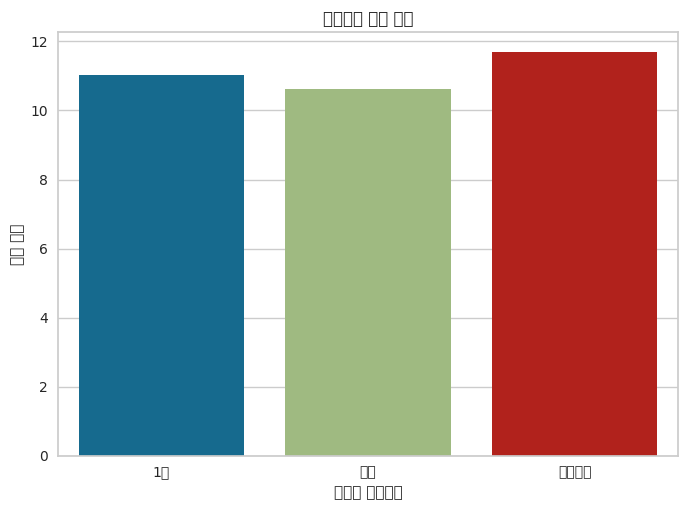

In [63]:
# 브랜드별 평균 가격
brand_avg_price = dt_concat_select.groupby('브랜드등급')['target'].mean().reset_index()

# 시각화
sns.barplot(x='브랜드등급', y='target', data=brand_avg_price)
plt.title('브랜드별 평균 가격')
plt.xlabel('브랜드 카테고리')
plt.ylabel('평균 가격')
plt.show()

#### 상관관계 확인
- 관리비부과면적, 주거전용면적, 전체세대수와 높은 상관관계를 보임

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

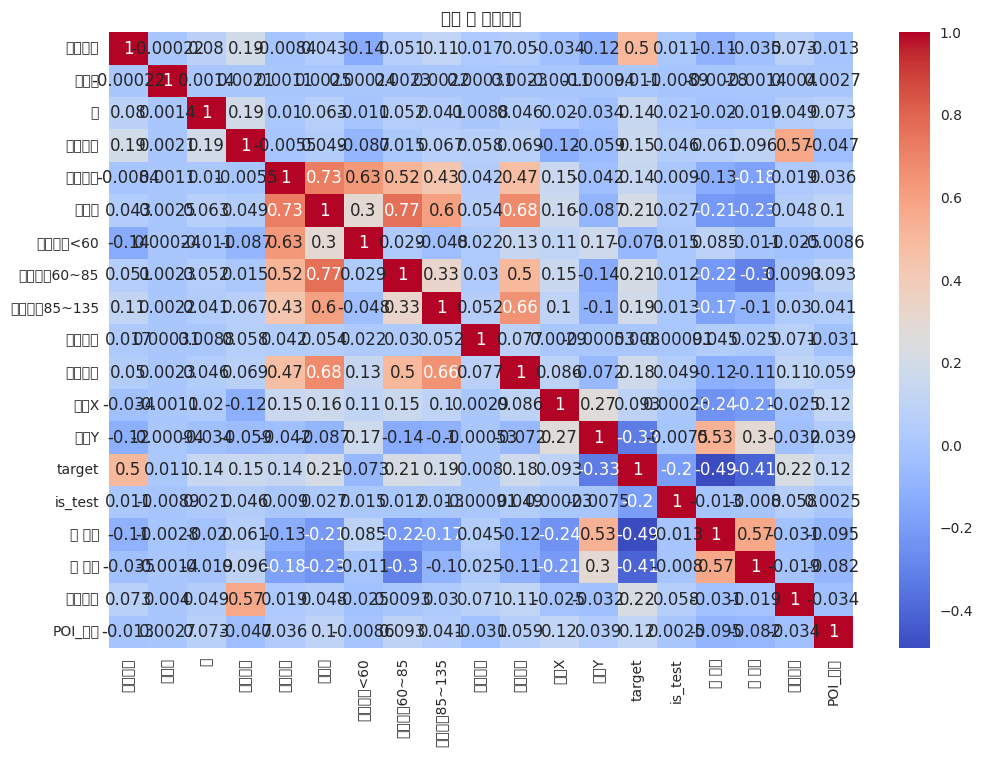

In [64]:
# 상관관계 행렬 계산
corr_matrix = dt_concat_select.corr()

# 상관관계 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('변수 간 상관관계')
plt.show()

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [65]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = dt_concat_select.query('is_test==0')
dt_test = dt_concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1021801, 49) (9272, 49)


In [66]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

In [67]:
dt_train['좌표Y'] = dt_train['좌표Y'].astype(float)
dt_train['좌표X'] = dt_train['좌표X'].astype(float)

In [68]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '전체동수', '연면적', '전용면적<60', '전용면적60~85', '전용면적85~135', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '구 티어', '동 티어', '신축여부', 'POI_개수']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', '단지분류', '전화번호', '팩스번호', '세대타입', '관리방식', '복도유형', '난방방식', '건설사', '시행사', 'k-사용검사일-사용승인일', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '시', '구', '동', '계약년', '계약월', '브랜드등급']


In [69]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 31/31 [00:08<00:00,  3.50it/s]


In [70]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,...,시,구,동,계약년,계약월,구 티어,동 티어,신축여부,POI_개수,브랜드등급
0,4264,1110,1,292,79.97,8,3,1987,5496,1,...,0,0,8,10,11,1,1,0,3,1


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [71]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [72]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [73]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=2023, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [74]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 0.09308960045803555


- 변수 중요도도 확인해보도록 하겠습니다.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

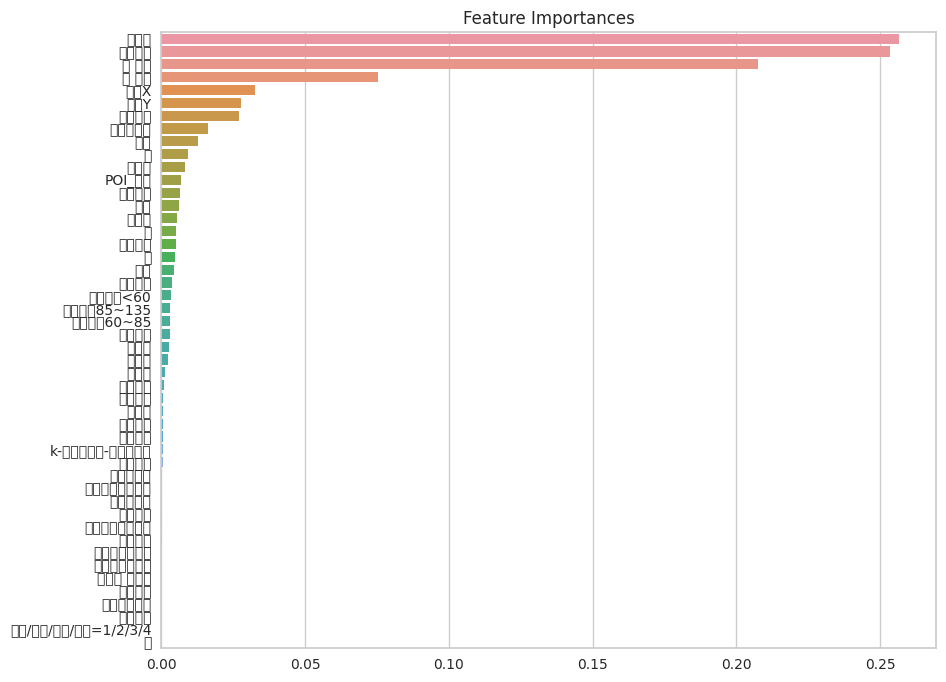

In [75]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [76]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [77]:
# # Permutation importance 계산
# result = permutation_importance(
#     model,                # 학습된 모델
#     X_val,                # 검증 데이터의 특성
#     y_val,                # 검증 데이터의 타겟
#     scoring="neg_mean_squared_error",   # 평가 지표 (회귀 문제이므로 음의 MSE 사용)
#     n_repeats=3,          # 반복 횟수
#     random_state=42
# )

# # 중요도 순서대로 정렬하여 출력
# importance_df = pd.DataFrame({
#     'feature': X_val.columns,
#     'importance_mean': result.importances_mean,
#     'importance_std': result.importances_std
# }).sort_values(by='importance_mean', ascending=False)

# # 결과 출력
# print(importance_df)

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [78]:
# # Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
# X_val['target'] = y_val
# X_val['pred'] = pred

In [79]:
# # Squared_error를 계산하는 함수를 정의하겠습니다.
# def calculate_se(target, pred):
#     squared_errors = (target - pred) ** 2
#     return squared_errors

# # RMSE 계산
# squared_errors = calculate_se(X_val['target'], X_val['pred'])
# X_val['error'] = squared_errors

In [80]:
# # Error가 큰 순서대로 sorting 해 보겠습니다.
# X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [81]:
# X_val_sort.head()

- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [82]:
# X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
# X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [83]:
# # 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
# error_top100 = X_val_sort_top100.copy()
# for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
#     error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

# best_top100 = X_val_sort_tail100.copy()
# for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
#     best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [84]:
# display(error_top100.head(1))
# display(best_top100.head(1))

- 이제 분포를 비교해보도록 하겠습니다.

In [85]:
# sns.boxplot(data = error_top100, x='target')
# plt.title('The worst top100 prediction의 target 분포')
# plt.show()

# sns.boxplot(data = best_top100, x='target', color='orange')
# plt.title('The best top100 prediction의 target 분포')
# plt.show()

In [86]:
# sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
# sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
# plt.title('전용면적 분포 비교')
# plt.show()

## 6. Inference

In [87]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,단지분류,...,시,구,동,계약년,계약월,구 티어,동 티어,신축여부,POI_개수,브랜드등급
1026850,4264,1110,1,292,79.9700,26,5,1987,5496,1,...,0,0,8,16,6,1,1,0,3,1
1026851,4240,1103,1,293,108.2017,15,10,2021,431,1,...,0,0,8,16,7,1,1,1,4,0


In [88]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [89]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
predicted_log2 = model.predict(X_test)
real_test_pred = np.expm1(predicted_log2)  # 원래 값으로 역변환

CPU times: user 20.9 ms, sys: 4.07 ms, total: 24.9 ms
Wall time: 19.9 ms


In [90]:
# %%time
# X_test = dt_test.drop(['target'], axis=1)

# # Test dataset에 대한 inference를 진행합니다.
# real_test_pred = model.predict(X_test)

In [91]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([201341.87382129, 248071.82708721, 238680.57618532, ...,
        88038.53936842,  82759.48189444,  82553.99938961])

## 7. Output File Save

In [92]:
# 테스트 데이터셋의 길이를 가져옵니다
num_test_rows = 9273 - 1  # 샘플 파일의 행 수에 맞춥니다

# 예측 값의 길이를 테스트 데이터셋 길이에 맞춥니다.
# 만약 예측 값이 부족한 경우에는 0 또는 평균값으로 채울 수 있습니다.
if len(real_test_pred) < num_test_rows:
    real_test_pred = np.pad(real_test_pred, (0, num_test_rows - len(real_test_pred)), 'constant', constant_values=real_test_pred.mean())

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)